# Using Low-Rank Kernel Matrix Approximation on OKGT -- Nystroem -- Gaussian Kernel

**Note** Gaussian kernel is used throughout this document.

This notebook tests the effect of using Nystroem kernel matrix approximation on OKGT. The Nystroem method is provided in `sklearn.kernel_approximation`.

We use the same model which is from [this post](http://partofthething.com/ace/samples.html). The following is the model representation:

$$
Y = \ln (4 + \sin(4X_0)) + |X_1| + X_2^2 + X_3^3 + X_4 + 0.1\epsilon
$$

where $\epsilon \sim N(0,1)$ and each covariate is simulated from $Unif(-1,1)$.

In [57]:
# Simulate data
import okgtreg.simulate as simulate
import okgtreg.kernel_selector as ks
import numpy as np
import scipy as sp
from sklearn.kernel_approximation import Nystroem

np.random.seed(10)
n = 500 # sample size
y, x = simulate.SimData_Wang04(n)
y = np.matrix(y)
x = np.matrix(x)

In [58]:
# Specify the constants, regularization coefficient and kernel functions
eps = 1e-6 # regularization term

p = x.shape[1]
xGroup = [[i+1] for i in range(p)]
kfn = ks.KernelSelector('Gaussian', sigma=0.5) # Gaussian kernel
# kfn = ks.KernelSelector('Laplace', alpha=0.3) # Laplace kernel
xkfnlist = [kfn]*p
ykfnlist = [kfn]

Next, we construct the Nystroem instance, and then estimate an approximation for our kernel matrices.

**Note** The [sklearn page](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem.fit_transform) doesn't show much information on how to use the Nystroem class. More information can be found in the [test codes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tests/test_kernel_approximation.py).

In [59]:
# Create Nystroem instance
nystroem = Nystroem(kfn, n_components=4)

print type(nystroem)

<class 'sklearn.kernel_approximation.Nystroem'>


In [60]:
# Use Nystroem on our data

# We define a function so that it can be applied on all variables.
def ApplyNystroemOnKernelMatrix(x, nystroem):
    return np.matrix(nystroem.fit_transform(x))

Get $G$ so that $K \approx G G^T$. **Note** Kernel matrix $K$ is not centered yet.

In [61]:
Gy = ApplyNystroemOnKernelMatrix(y, nystroem)

print 'Gy type and dimension:\n', type(Gy), Gy.shape

Gy type and dimension:
<class 'numpy.matrixlib.defmatrix.matrix'> (500, 4)


Apply SVD on $N_0G = USV$, where $N_0$ is a centering matrix. Then we can have $N_0 K N_0 \approx U S^2 U^T$. Denote $\Lambda := S^2$.

In [62]:
# SVD
N0 = np.identity(n) - np.ones((n,n))/n
Uy, Gy_s, Gy_V = np.linalg.svd(N0 * Gy, full_matrices=0)
lambday = Gy_s**2

print 'Uy type and dimension:\n', type(Uy), Uy.shape
print 'Retained eigen values of Ky:\n', lambday

Uy type and dimension:
<class 'numpy.matrixlib.defmatrix.matrix'> (500, 4)
Retained eigen values of Ky:
[  2.14232714e+01   1.60739755e+00   6.71512656e-02   1.07845060e-03]


In [63]:
# Do the same thing for all X
Ux = []
lambdax = []
for i in range(p):
    Gi = ApplyNystroemOnKernelMatrix(x[:,i], nystroem)
    print 'Gi shape:', Gi.shape
    Ui, Gi_s, Gi_V = np.linalg.svd(N0 * Gi, full_matrices=0)
    print 'Ui shape:', Ui.shape
    Ux.append(Ui)
    lambdai = Gi_s**2
    print 'lambdai:', lambdai
    lambdax.append(lambdai)

Gi shape: (500, 4)
Ui shape: (500, 4)
lambdai: [  9.89380062e+01   1.69660413e+01   1.04994115e+00   1.62082228e-02]
Gi shape: (500, 4)
Ui shape: (500, 4)
lambdai: [  1.03942540e+02   1.73409543e+01   1.16004436e+00   1.37468667e-02]
Gi shape: (500, 4)
Ui shape: (500, 4)
lambdai: [  1.01390502e+02   1.66066446e+01   1.08363160e+00   1.93996448e-02]
Gi shape: (500, 4)
Ui shape: (500, 4)
lambdai: [  1.02128757e+02   1.64196638e+01   8.45166255e-01   3.35006662e-02]
Gi shape: (500, 4)
Ui shape: (500, 4)
lambdai: [  9.64215984e+01   1.66986368e+01   7.85293349e-01   3.12203028e-02]


Then, we construct the necessary matrices for estimating covariance and cross-covariance operators.

In [64]:
# Construct covariance operators
lambdax_row = np.hstack(lambdax)
Ux_row = np.hstack(Ux)
Ux_diag = sp.sparse.block_diag(Ux)

T = np.diag(lambday / (lambday + eps)) * Uy.T * Ux_row * np.diag(lambdax_row)
R = np.diag((lambdax_row + eps)**2) + \
        np.diag(lambdax_row) * (Ux_row.T * Ux_row - np.identity(len(lambdax_row))) * np.diag(lambdax_row)
    
R_inv = np.linalg.inv(R)

In [65]:
vv = T*R_inv*T.T # this matrix is much smaller than the estimator in our paper

In [66]:
my = vv.shape[0]
eigval, eigvec = sp.linalg.eigh(vv, eigvals=(my-1, my-1))

print 'Largest eigen value = ', float(eigval)

Largest eigen value =  0.980530612534


In [67]:
g_opt = Uy * np.diag(lambday) * np.matrix(eigvec)

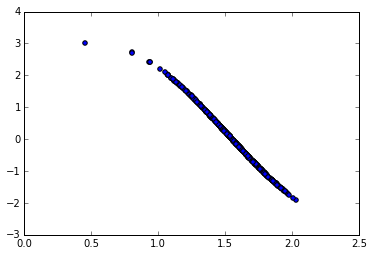

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(y, g_opt)

In [69]:
f_opt = np.diag(np.sqrt(lambday**2 + eps) * lambday) * np.matrix(eigvec)
f_opt = T.T * f_opt
f_opt = R_inv * f_opt
f_opt = np.diag(lambdax_row) * f_opt
f_opt = Ux_diag * f_opt

f_opt = f_opt.reshape((n, p), order='F')

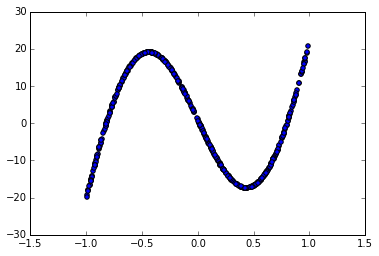

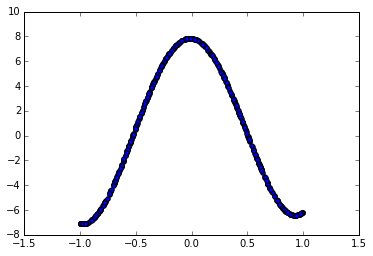

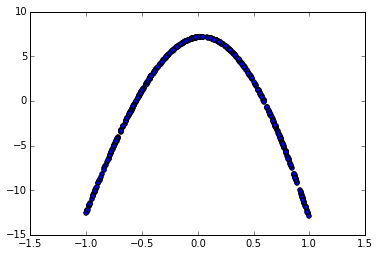

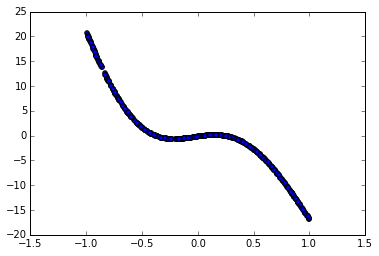

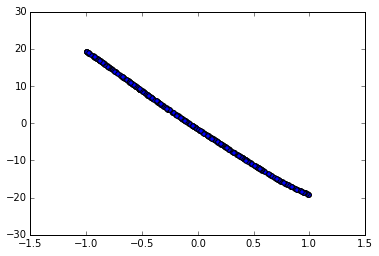

In [70]:
plt.figure()
plt.scatter(x[:,0], f_opt[:,0])
plt.show()

plt.figure()
plt.scatter(x[:,1], f_opt[:,1])
plt.show()

plt.figure()
plt.scatter(x[:,2], f_opt[:,2])
plt.show()

plt.figure()
plt.scatter(x[:,3], f_opt[:,3])
plt.show()

plt.figure()
plt.scatter(x[:,4], f_opt[:,4])
plt.show()